In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-26 10:19:02.754063: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Dados simulados ##

In [2]:
means = [2.0,3.0,4.0]
stds = [0.7, 1.2, 2.5]
ts = np.zeros((200,3))
x = np.arange(200)
for i in range(3):
    ts[:,i] = stds[i]*np.sin(x/10-i*np.pi/2) + means[i]

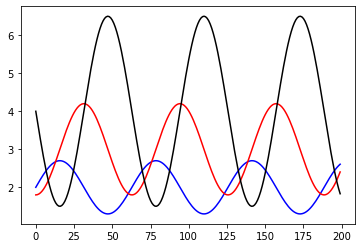

In [3]:
plt.plot(ts[:,0],'b')
plt.plot(ts[:,1],'r')
plt.plot(ts[:,2],'k')

# Para exemplificar a utilização de um transformer numa tarefa de segmentação, pretende-se, neste exemplo identificar, em cada momento qual dos três sinais toma o maior valor (tarefa trivial) #

In [4]:
seg = np.argmax(ts, axis=-1)

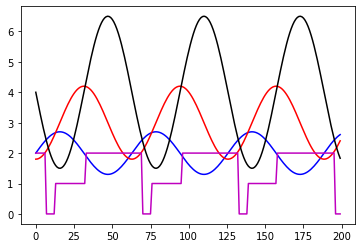

In [5]:
plt.plot(ts[:,0],'b')
plt.plot(ts[:,1],'r')
plt.plot(ts[:,2],'k')
plt.plot(seg,'m')

In [6]:
inputsData = np.array([ts[i:i+20] for i in range(180)])
print(inputsData.shape)
targets = np.array([seg[i:i+20] for i in range(180)])
targets.shape

(180, 20, 3)


(180, 20)

# Código para definir um 'transformer encoder' #

In [7]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [9]:
inputs = keras.Input(shape=(20,3))
embDim = 10
newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
inputsPosEmb = PositionEmbedding(maxlen=20, embed_dim=embDim)(newEmb)
transf1 = TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(inputsPosEmb)
transf2 =TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(transf1)
out = layers.TimeDistributed(layers.Dense(3))(transf2)

transf_model = keras.Model(inputs=inputs, outputs=out)

2022-05-26 10:19:03.886052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-26 10:19:03.944483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 10:19:03.944783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-05-26 10:19:03.944804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-26 10:19:03.946633: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-26 10:19:03.946681: I tensorflow/stream_executor/platform/d

In [10]:
transf_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 10)            40        
_________________________________________________________________
position_embedding (Position (None, 20, 10)            200       
_________________________________________________________________
transformer_block (Transform (None, 20, 10)            1518      
_________________________________________________________________
transformer_block_1 (Transfo (None, 20, 10)            1518      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3)             33        
Total params: 3,309
Trainable params: 3,309
Non-trainable params: 0
___________________________________________________________

In [ ]:
lr = 1.0e-4
opt = tf.keras.optimizers.Adam(learning_rate=lr)
transf_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics = 'accuracy')
transf_model.fit(inputsData, targets, batch_size=4, epochs = 50)

## Usar uma rede recorrente (LSTM) para fazer previsões neste 'dataset' ##